# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 1**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1i3NlGFJbY6hvm-ropSFobW9_nqUcqzPS?usp=sharing)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

Взят датасет отсюда:
https://www.kaggle.com/datasets/vimpigro/handwritten-mongolian-cyrillic-characters-database

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

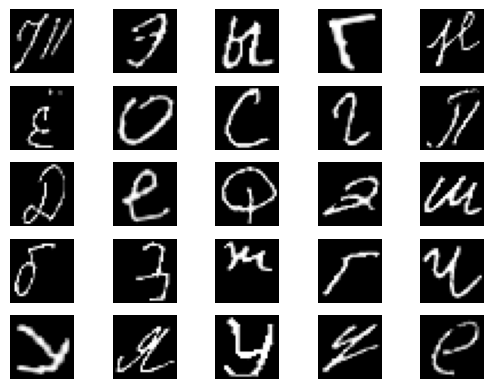

In [158]:
r, c = 5, 5
fig, axs = plt.subplots(r, c)
cnt = 0
idx = np.random.randint(0, X_train.shape[0], 25)
imgs = X_train[idx]

for i in range(r):
    for j in range(c):
        img = cv2.cvtColor(imgs[cnt], cv2.COLOR_BGR2RGB)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1

plt.show()

In [111]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

from sklearn.model_selection import train_test_split
from imutils import paths
import random 
import cv2

## Конструктор генератора

In [40]:
def build_generator():
    # Вектор случайного шума, используемый в качестве входного слоя для Генератора:
    noise_shape = (100,) # 1D массив размером 100 (латентный вектор / шум) 

    model = Sequential()

    #Alpha - α - это гиперпараметр, который управляет базовым значением, на который функция
    # функция домножает отрицательные входы сети.
    #Momentum - «задержка» в обучении среднего значения и дисперсии, поэтому шум из-за мини-пакета можно игнорировать
    # Ссылка: https://medium.com/@ilango100/batchnorm-fine-tune-your-booster-bef9f9493e22

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.4))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.4))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.4))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)

## Конструктор дискриминатора

In [41]:
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)  # предположение дискриминатора о том, является ли входное изображение реальным или нет.

    return Model(img, validity)

### Функции для сохранения и загрузки

In [35]:
from tensorflow.keras.models import load_model, save_model
import os

models_path = r'model'
gan_path = models_path + '\\' + "gan"
generator_path = models_path + '\\' + "generator"
discriminator_path = models_path + '\\' + "discriminator"

Path(gan_path).mkdir(parents=True, exist_ok=True)
Path(generator_path).mkdir(parents=True, exist_ok=True)
Path(discriminator_path).mkdir(parents=True, exist_ok=True)

def save(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, gan_path)
    discriminator.trainable = True
    save_model(generator, generator_path)
    save_model(discriminator, discriminator_path)

def load():
    discriminator = load_model(discriminator_path)
    generator = load_model(generator_path)
    gan = load_model(gan_path)
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [134]:
data = pd.read_csv('./HMCC similar merged.csv')
X_train = data.to_numpy()
X_train, y = X_train[:,1:], X_train[:,0]
X_train = X_train.reshape((-1, 28, 28))
X_train = np.expand_dims(X_train, axis=3)

In [135]:
X_train.shape

(257249, 28, 28, 1)

In [137]:
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

In [138]:
def train(epochs, batch_size=128, save_interval=50):

    print(X_train.shape)
    # Преобразование в тип float и нормализация от -1 до 1 (можно также от 0 до 1)
    #X_train = X_train.astype(np.float32) / 255.0

    half_batch = int(batch_size / 2)
    print(X_train.shape)
    
    half_batch = int(batch_size / 2)
    progress = tqdm(total=epochs)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size)
  
        g_loss = combined.train_on_batch(noise, valid_y)
        
        status = "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)
        progress.set_description_str(status)
        progress.update(1)

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            progress.write("Saving images...")
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                progress.write("Saving models...")
                save(combined, generator, discriminator)



In [139]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise, verbose=0)

    # use if data is normalized between -1 and 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            img = cv2.cvtColor(gen_imgs[cnt], cv2.COLOR_BGR2RGB)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            cnt += 1
            
    Path('gen_images').mkdir(parents=True, exist_ok=True)
    fig.savefig('gen_images' + '\\' + f'epoch_{epoch}.png')
    plt.close()

In [140]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# Определим наш оптимизатор для удобства использования в дальнейшем.
optimizer = Adam(0.0002, 0.5)  #Скорость обучения и экспоненциальная скорость затухания для оценок первого момента.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img) 

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
combined = load()[0]
generator = load()[1]
discriminator = load()[2]

In [141]:
train(
    25000,
    batch_size=128, 
    save_interval=2000
)

generator.save('generator_model_final_5.h5')

(257249, 28, 28, 1)
(257249, 28, 28, 1)


  0%|          | 0/25000 [00:00<?, ?it/s]

Saving images...
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets
Saving images...
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets
Saving images...
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets
Saving images...
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written to: model\discriminator\assets
Saving images...
Saving models...
INFO:tensorflow:Assets written to: model\gan\assets
INFO:tensorflow:Assets written to: model\generator\assets
INFO:tensorflow:Assets written t

### Демонстрация сгенерированных изображений:

In [173]:
from keras.models import load_model

gen = load_model('./att1_mong/generator_model_final_5.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

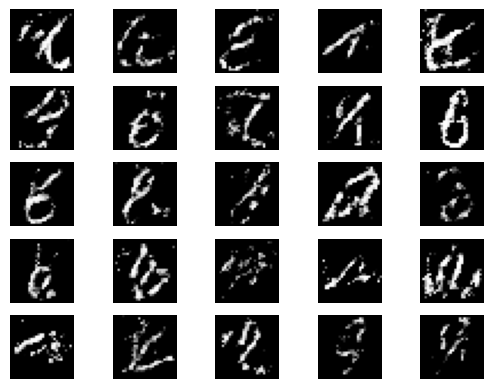

In [157]:
r, c = 5, 5
fig, axs = plt.subplots(r, c)
cnt = 0
noise = np.random.normal(0, 1, (25, 100))
gen_imgs = gen.predict(noise, verbose=0)

for i in range(r):
    for j in range(c):
        img = cv2.cvtColor(gen_imgs[cnt], cv2.COLOR_BGR2RGB)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1

plt.show()

1/1 [==============================] - 0s 163ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


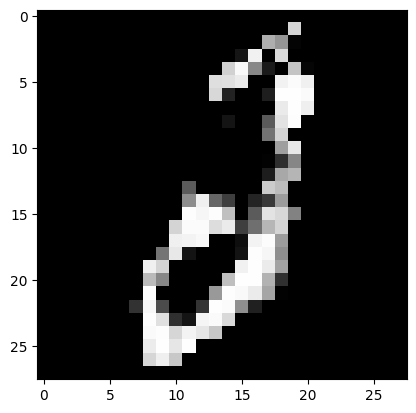

In [174]:
noise = np.random.normal(0, 1, (1, 100))
gen_image = gen.predict(noise)

plt.figure()
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


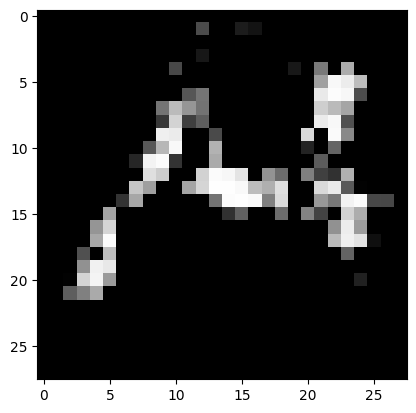

In [175]:
noise = np.random.normal(0, 1, (1, 100))
gen_image = gen.predict(noise)

plt.figure()
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


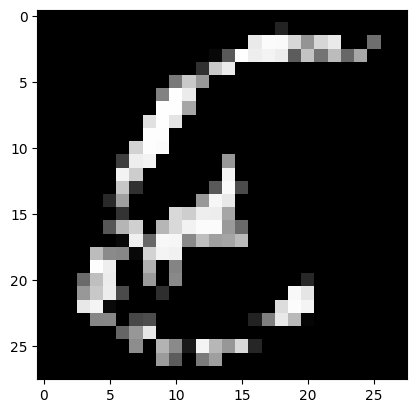

In [180]:
noise = np.random.normal(0, 1, (1, 100))
gen_image = gen.predict(noise)

plt.figure()
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2RGB))

# **Задание №2.** Обучите генератор воспризводить сложные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/fedesoriano/cifar100))

Датасет взят отсюда: https://www.kaggle.com/datasets/ashkanforootan/gan-animated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

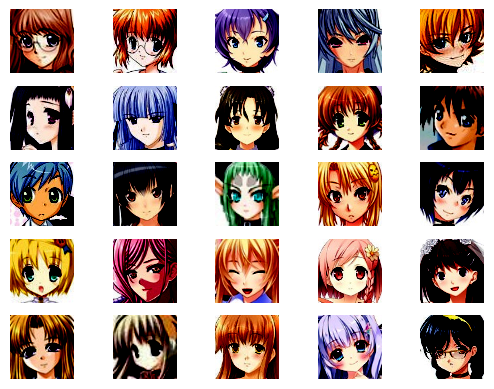

In [160]:
r, c = 5, 5
fig, axs = plt.subplots(r, c)
cnt = 0
idx = np.random.randint(0, X_train.shape[0], 25)
imgs = X_train[idx]

for i in range(r):
    for j in range(c):
        img = cv2.cvtColor(imgs[cnt], cv2.COLOR_BGR2RGB)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1

plt.show()

In [159]:
X_train = np.load('./anime_imgs.npy')
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

In [ ]:
def train(epochs, batch_size=128, save_interval=50):

    half_batch = int(batch_size / 2)
    
    progress = tqdm(total=epochs)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))) 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
        
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        valid_y = np.array([1] * batch_size)
  
        g_loss = combined.train_on_batch(noise, valid_y)
        
        status = "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)
        progress.set_description_str(status)
        progress.update(1)

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            progress.write("Saving images...")
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                progress.write("Saving models...")
                save(combined, generator, discriminator)



In [ ]:
img_rows = 64
img_cols = 64
channels = 3
img_shape = (img_rows, img_cols, channels)

# Определим наш оптимизатор для удобства использования в дальнейшем.
optimizer = Adam(0.0002, 0.5)  #Скорость обучения и экспоненциальная скорость затухания для оценок первого момента.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img) 

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
train(
    25000,
    batch_size=128, 
    save_interval=2000
)

generator.save('generator_model_final_4.h5')

### Демонстрация сгенерированных изображений:

In [161]:
from keras.models import load_model

gen = load_model('./att3_anime/generator_model_final_3.h5')

~53 000 эпох

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

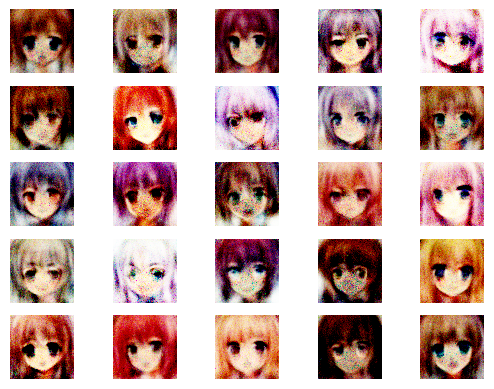

In [172]:
r, c = 5, 5
fig, axs = plt.subplots(r, c)
cnt = 0
noise = np.random.normal(0, 1, (25, 100))
gen_imgs = gen.predict(noise, verbose=0)

for i in range(r):
    for j in range(c):
        img = cv2.cvtColor(gen_imgs[cnt], cv2.COLOR_BGR2RGB)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        cnt += 1

plt.show()

1/1 [==============================] - 0s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


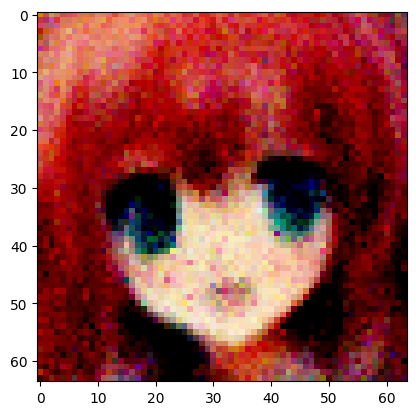

In [97]:
noise = np.random.normal(0, 1, (1, 100))
gen_image = gen.predict(noise)

plt.figure()
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 32ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


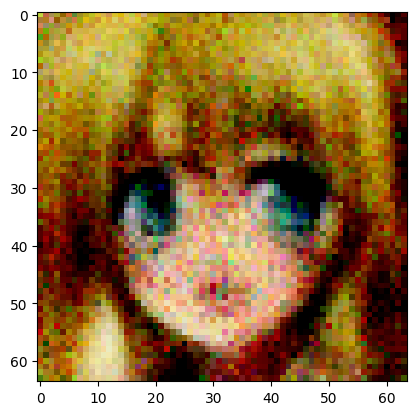

In [52]:
noise = np.random.normal(0, 1, (1, 100))
gen_image = gen.predict(noise)

plt.figure()
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


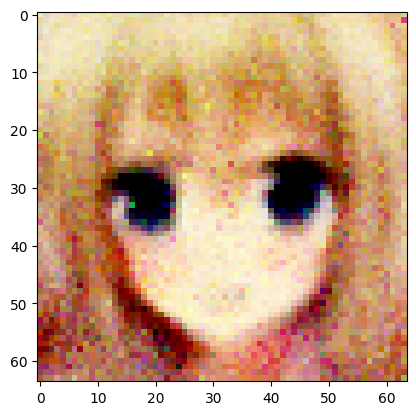

In [309]:
noise = np.random.normal(0, 1, (1, 100))
gen_image = gen.predict(noise)

plt.figure()
plt.imshow(cv2.cvtColor(gen_image[0], cv2.COLOR_BGR2RGB))